In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers, Model
from sklearn.metrics import classification_report, f1_score
import cv2

In [56]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [57]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Data400',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1200 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_5292\1034064226.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Data400',


In [58]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [59]:
len(dataset)

38

In [60]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 2 2 0 0 2 2 0 0 2 2 2 1 0 2 1 2 2 0 2 2 0 2 2 1 0 0 0 0 1]


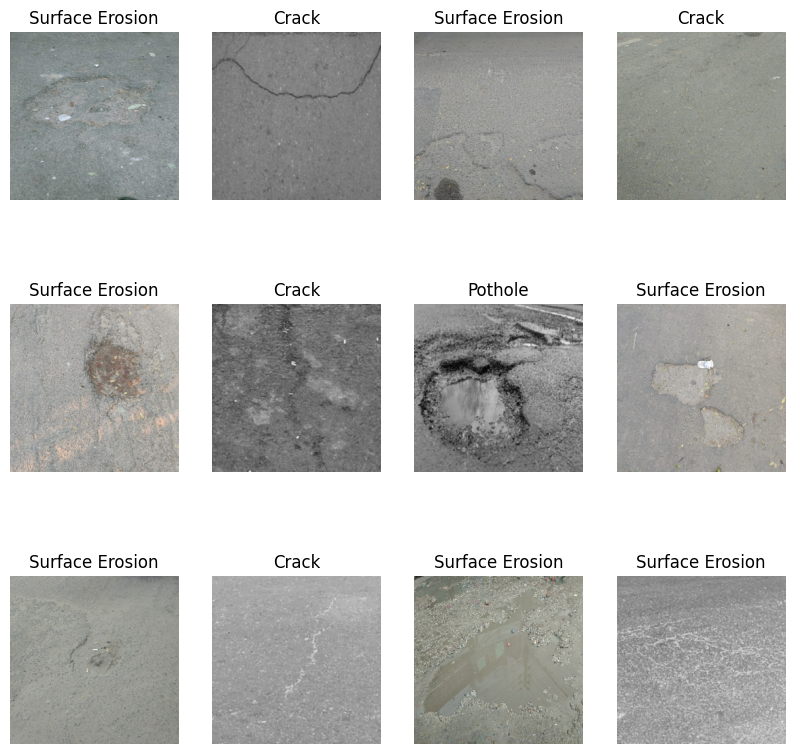

In [61]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [62]:
def partition_data(dataset, train_size=0.8, validation_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * validation_size)
    test_size = int(total_size * test_size)
    train_data = dataset.take(train_size)
    remaining_data = dataset.skip(train_size)
    
    validation_data = remaining_data.take(validation_size)
    test_data = remaining_data.skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 30
Validation data size: 3
Test data size: 5


In [63]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [64]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [65]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [66]:
n_classes = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
#model.build(input_shape=input_shape)

In [67]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [69]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3175 - loss: 1.1082 - val_accuracy: 0.3542 - val_loss: 1.0911
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 893ms/step - accuracy: 0.3254 - loss: 1.1007 - val_accuracy: 0.3646 - val_loss: 1.0638
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 929ms/step - accuracy: 0.3835 - loss: 1.0752 - val_accuracy: 0.5938 - val_loss: 0.8506
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 919ms/step - accuracy: 0.5378 - loss: 0.9150 - val_accuracy: 0.5417 - val_loss: 0.8785
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 932ms/step - accuracy: 0.5006 - loss: 0.9555 - val_accuracy: 0.5833 - val_loss: 0.8180
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 918ms/step - accuracy: 0.5049 - loss: 0.9266 - val_accuracy: 0.5938 - val_loss: 0.8384
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 955ms/step - accuracy: 0.5159 - loss: 0.9027 - val_accuracy: 0.5521 - val_loss: 0.9242
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 963ms/step - accuracy: 0.5180 - loss: 0.9565 - val_accurac

In [70]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.8470 - loss: 0.3569


[0.4114841818809509, 0.8263888955116272]

In [71]:
model.save("Trained Aug Models/CNN.h5")

In [72]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 30}

In [73]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [74]:
history.history['accuracy']

[0.33541667461395264,
 0.3583333194255829,
 0.4468750059604645,
 0.49791666865348816,
 0.5104166865348816,
 0.5197916626930237,
 0.5385416746139526,
 0.550000011920929,
 0.596875011920929,
 0.6166666746139526,
 0.6583333611488342,
 0.6760416626930237,
 0.6875,
 0.6666666865348816,
 0.7145833373069763,
 0.7333333492279053,
 0.7093750238418579,
 0.715624988079071,
 0.7354166507720947,
 0.7322916388511658,
 0.734375,
 0.746874988079071,
 0.7677083611488342,
 0.7666666507720947,
 0.7583333253860474,
 0.7718750238418579,
 0.7447916865348816,
 0.7864583134651184,
 0.765625,
 0.784375011920929,
 0.78125,
 0.78125,
 0.7749999761581421,
 0.793749988079071,
 0.7895833253860474,
 0.8020833134651184,
 0.7989583611488342,
 0.8031250238418579,
 0.8062499761581421,
 0.7989583611488342,
 0.8052083253860474,
 0.8291666507720947,
 0.8145833611488342,
 0.8072916865348816,
 0.8125,
 0.8197916746139526,
 0.8229166865348816,
 0.846875011920929,
 0.831250011920929,
 0.8374999761581421]

In [75]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
F1 Score (macro): 0.823562758436708
F1 Score (weighted): 0.8292150193410698

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.90      0.86      0.88        50
        Pothole       0.90      0.80      0.84        54
Surface Erosion       0.69      0.82      0.75        40

       accuracy                           0.83       144
      macro avg       0.83      0.83      0.82       144
   weighted avg       0.84      0.83      0.83       144



In [76]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

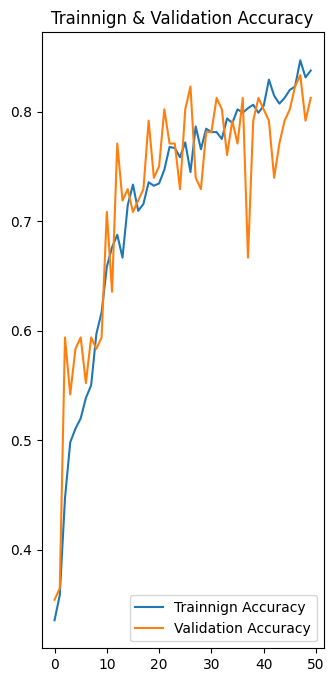

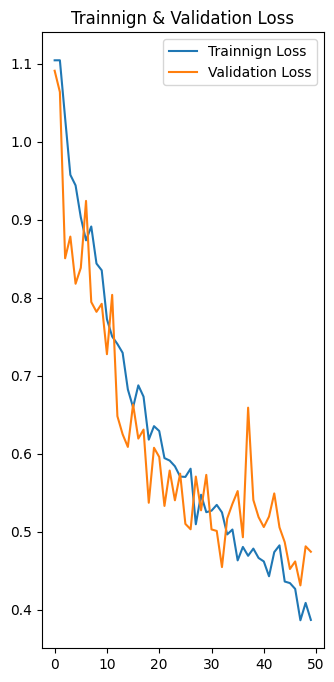

In [77]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [78]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.8245 - loss: 0.4208


[0.4114841818809509, 0.8263888955116272]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Predicted Label:  Surface Erosion


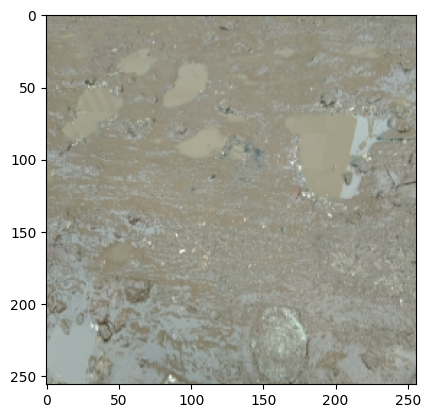

In [79]:
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [80]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->68.63999938964844 Light:-> Normal lighting
Confidence:->60.88999938964844 Light:-> Normal lighting
Confidence:->99.91000366210938 Light:-> Normal lighting
Confidence:->60.63999938964844 Light:-> Normal lighting
Confidence:->99.73999786376953 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->91.69999694824219 Light:-> Normal lighting
Confidence:->99.9800033569336 Light:-> Normal lighting
Confidence:->99.80000305175781 Light:-> Normal lighting


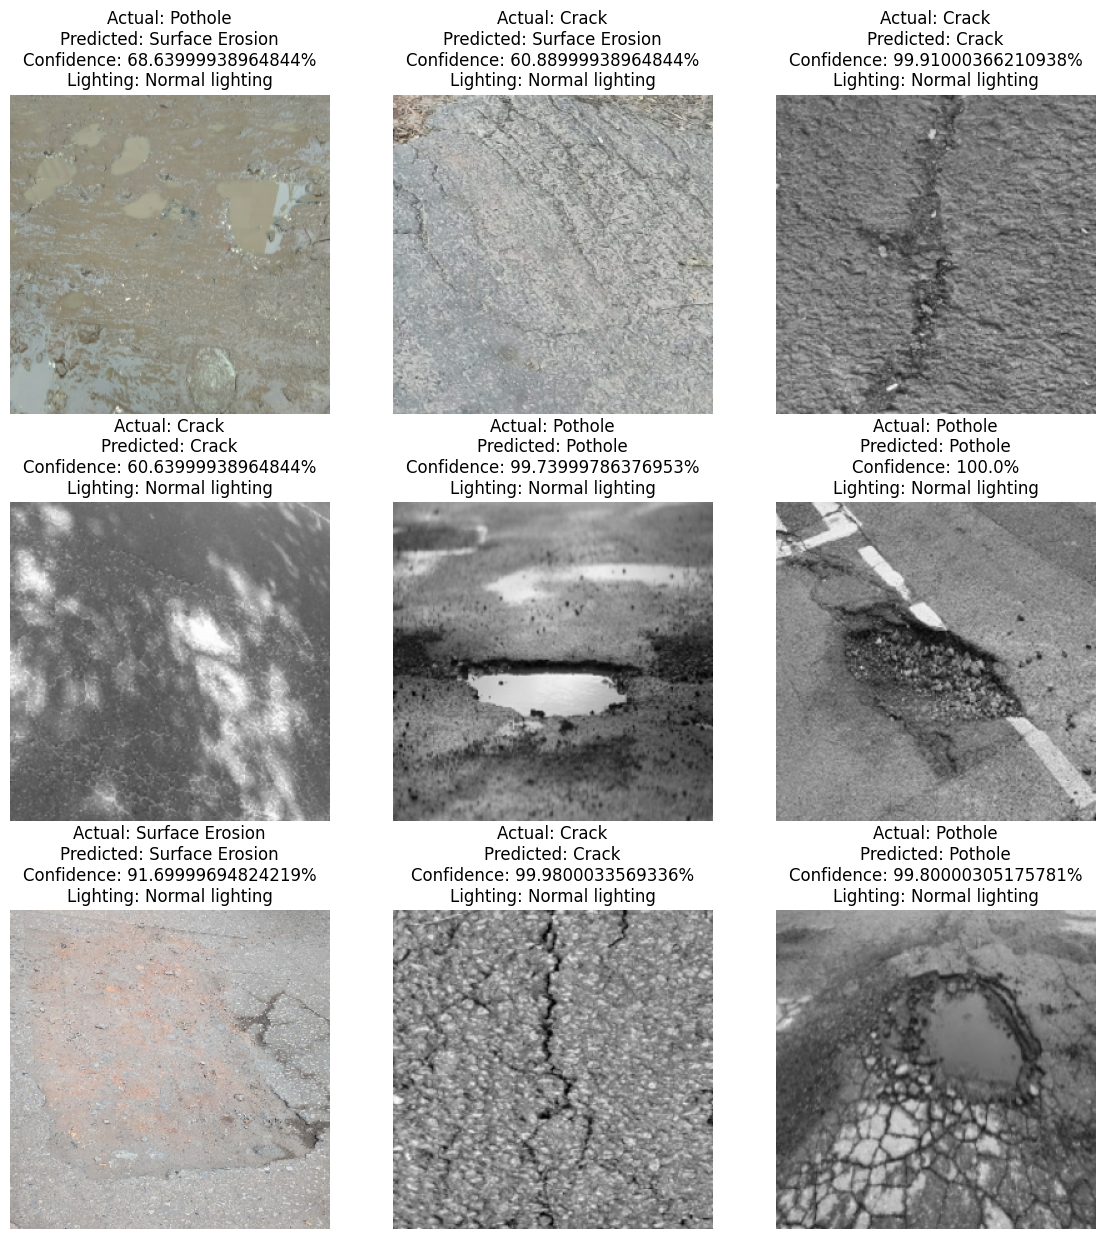

In [81]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [82]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Pothole, Confidence: 99.80000305175781


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


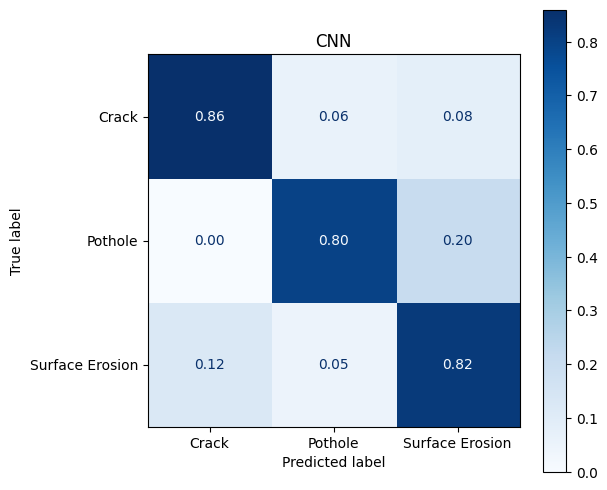

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("confusion_matrix_CNN.png", dpi=300, bbox_inches='tight')
plt.show()


In [88]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)


conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5
